<a href="https://colab.research.google.com/github/valeria-edulabs/ai-experts/blob/main/meeting14/solutions_for_eda_part_3.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,7)})

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [122]:
url = 'https://storage.googleapis.com/edulabs-public-datasets/athlete_events.zip'

converters = {
    "Sex": lambda s: s == 'M', # return True if Male, false if Female
    "Season": lambda s: s == 'Summer'  # return True if Summer, false if Winter
}
dtypes = {
    "ID": "int32",
    "Age": "Int8",
    "Height": "float32",
    "Weight": "float32",
    "Year": "Int16",
    "Medal": "category"
}
usecols = [
    'ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal'
]  # all the columns except for "Games" which is redundant

df = pd.read_csv(url, usecols=usecols, converters=converters, dtype=dtypes)

df.rename(columns={"Sex": "male", "Season": "summer"}, inplace=True)
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)


# Solutions

In [ ]:
athletes = df.drop_duplicates(subset=['id'])

In [ ]:

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = athletes["height"].quantile(0.25)
Q3 = athletes["height"].quantile(0.75)

print(f"Q1: {Q1}, Q3: {Q3}")

# Calculate IQR
IQR = Q3 - Q1
print(f"IQR: {IQR}")

# Define lower and upper bounds for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower: {lower_bound}")
print(f"upper_bound: {upper_bound}")

# Detect anomalies
anomalies = (athletes["height"] < lower_bound) | (athletes["height"] > upper_bound)

# Show anomalies
athletes[anomalies]

####**❓Exercise: Find amount of anomalies (in terms of age) per sport**

In [ ]:
temp = athletes[['sport', 'age']].groupby(['sport']).agg([lambda col: col.quantile(0.25), lambda col: col.quantile(0.75)]).droplevel(level=0, axis=1)
temp.columns=['Q1', 'Q3']
temp['IQR'] = temp['Q3'] - temp['Q1']
temp['lower_bound'] = temp['Q1'] - 1.5 * temp['IQR']
temp['upper_bound'] = temp['Q3'] + 1.5 * temp['IQR']
temp

,Q1,Q3,IQR,lower_bound,upper_bound
sport,,,,,
Aeronautics,26.00,26.0,0.00,26.000,26.000
Alpine Skiing,20.00,24.0,4.00,14.000,30.000
Alpinism,33.00,47.5,14.50,11.250,69.250
Archery,21.00,32.0,11.00,4.500,48.500
Art Competitions,34.25,52.0,17.75,7.625,78.625
...,...,...,...,...,...
Tug-Of-War,24.00,33.0,9.00,10.500,46.500
Volleyball,22.00,26.0,4.00,16.000,32.000
Water Polo,21.00,26.0,5.00,13.500,33.500


In [ ]:
for g in athletes[['sport', 'age', 'weight']].groupby('sport'):
    print(g)
    print(type(g))
    break

('Aeronautics',               sport  age  weight
214105  Aeronautics   26     NaN)
<class 'tuple'>


In [ ]:
def calc_anomalies(group_df):
    if len(group_df) == 0:
        return 0
    sport = group_df['sport'].iloc[0]
    upper_bound = temp.loc[sport, 'upper_bound']
    lower_bound = temp.loc[sport, 'lower_bound']
    return ((group_df['age'] > upper_bound) | (group_df['age'] < lower_bound)).sum()

In [ ]:
athletes[['sport', 'age']].groupby('sport').apply(calc_anomalies, include_groups=True)

<ipython-input-120-dcc984958ad9>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  athletes[['sport', 'age']].groupby('sport').apply(calc_anomalies, include_groups=True)


,0
sport,
Aeronautics,0
Alpine Skiing,50
Alpinism,0
Archery,31
Art Competitions,5
...,...
Tug-Of-War,0
Volleyball,53
Water Polo,45


#### ❓**Exercise: Find Sport with maximum and minimum std of: athlete height, weight, age**

In [ ]:
t = athletes[['height', 'weight', 'age', 'sport']].groupby('sport').std()

In [ ]:
t['height'].idxmax()

'Basketball'

In [ ]:
t['height'].idxmin()

'Polo'

#### ❓**Exercise**


*   Use scatterplot to see whether there is a correlation between age and height in all the athletes dataset
*   Use scatterplot to see whether there is a correlation between age and weight in all the athletes dataset

Answer the same questions for Hockey athletes



Answer: It looks like there is some kind of correlation!

- the minimnal hieght increases with age
- the variance of height reduces with age

It might mean either that higher athletes more durable, or that there are sports that require higher athletes, but also they don't have to be too young

<Axes: xlabel='age', ylabel='height'>

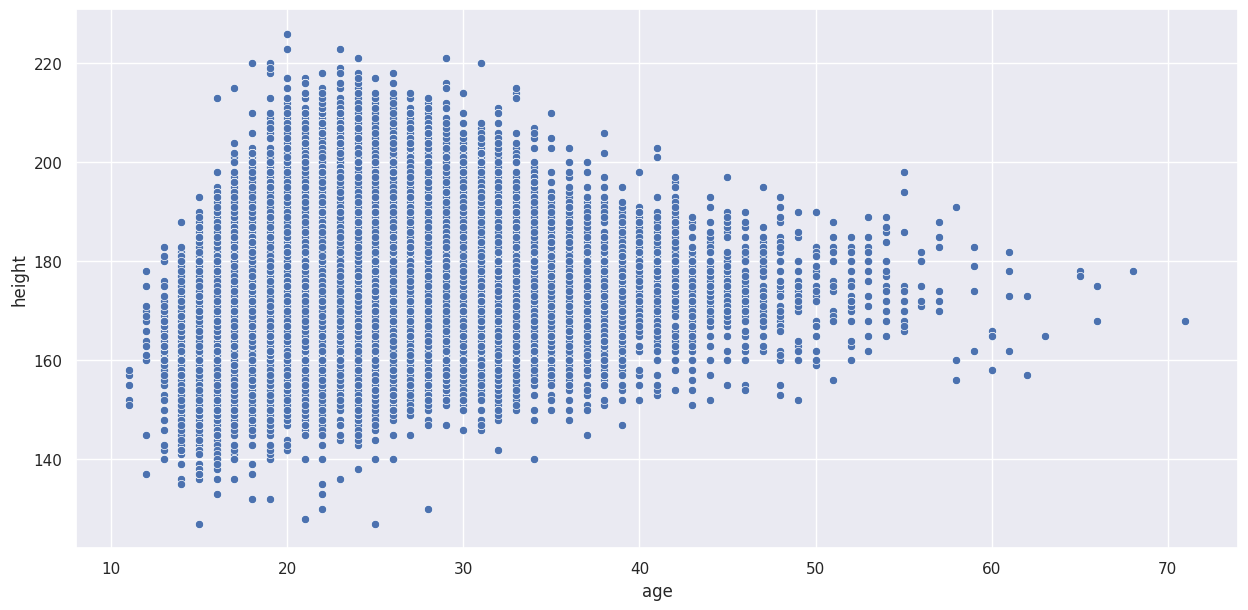

In [ ]:
# all athletes age vs hieght
sns.scatterplot(athletes, x='age', y='height')


<Axes: xlabel='age'>

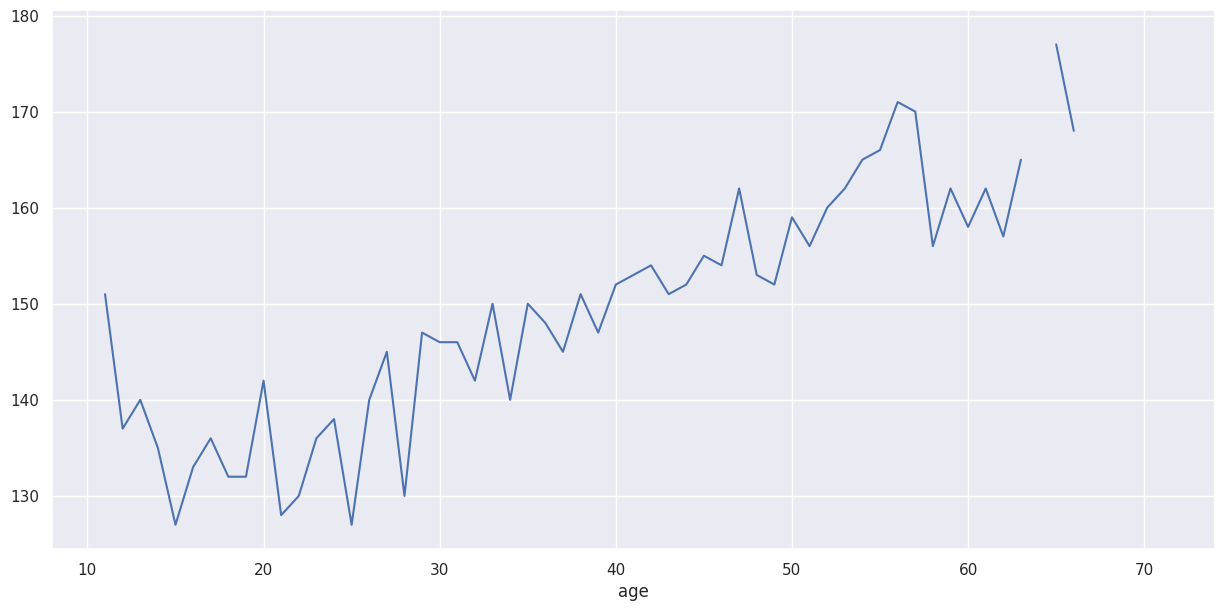

In [ ]:
mean_height_per_age = athletes[['age', 'height']].groupby("age").min()['height']
mean_height_per_age.plot()

#### ❓**Exercise**


Lets see how athletes physical attributes changed over time.

Plot figures to show whether athletes median age / weight / height changed overtime, **per sport**.



In [ ]:
medians = athletes[['age', 'weight', 'height', 'year', 'sport']].groupby(['sport', 'year']).quantile(0.5)
medians

age  weight  height
sport         year                      
Aeronautics   1936  26.0     NaN     NaN
Alpine Skiing 1936  23.0    60.0   168.0
              1948  24.0    67.0   171.5
              1952  23.0    66.5   172.0
              1956  23.0    65.0   168.0
...                  ...     ...     ...
Wrestling     2000  25.0    74.0   173.0
              2004  24.0    72.0   171.0
              2008  24.0    69.5   170.0
              2012  24.0    70.0   172.0
              2016  25.0    73.0   170.0

[905 rows x 3 columns]

In [ ]:
medians.reset_index(inplace=True)


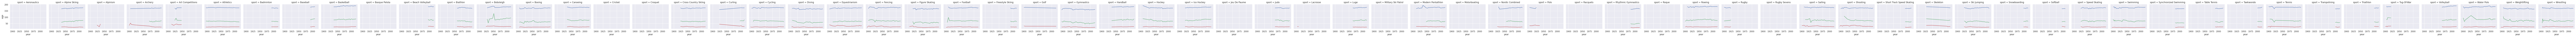

In [ ]:
g = sns.FacetGrid(medians, col='sport')

# Plot a scatter plot for each category
g.map(sns.lineplot, 'year', 'height', color='b')
g.map(sns.lineplot, 'year', 'weight', color='g')
g.map(sns.lineplot, 'year', 'age', color='r')

# Additional questions

**Display on graph how many athletes participated in the Olympics per year**

If possible, differentiate between female and male athletes.


In the past homework, you create a dataframe that presents how many medals of each kind every country achieved during the history of the olympics

In [123]:
total_medals = df.groupby(['noc','medal'], observed=True).count()[['event']].rename(columns={'event': 'total_medals'})
total_medals

total_medals
noc medal               
AFG Bronze             2
AHO Silver             1
ALG Bronze             8
    Gold               5
    Silver             4
...                  ...
ZAM Bronze             1
    Silver             1
ZIM Bronze             1
    Gold              17
    Silver             4

[362 rows x 1 columns]

**Use this dataframe and plot a graph that represents the data in it**